Plots interpolation/approximation demonstration.

Copyright: 2022, Mitja Jančič for Jozef Stefan Institute

# Libs

In [1]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from numpy import true_divide
import matplotlib
from numpy import linalg as LA
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit

/home/mjancic/.local/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# from matplotlib import interactive

# interactive(True)
# %matplotlib qt

In [3]:
plt.rcParams.update({
    "mathtext.fontset": "cm",
    "font.family": "STIXGeneral",
    "text.usetex": False,
    "axes.formatter.use_mathtext": True,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.labelsize": 14
})

In [4]:
source_file = '../data/interpolation_mon_4.h5'
sup_sheppard = 3
sup_pu = 31
sup_rbffd = 31
with h5.File(source_file, 'r') as data:
    # Get data.
    positions_fit = data['fit_domain']['pos'][:]
    positions_test = data['test_domain']['pos'][:]
    sol_analytic = data['analytic'][:][0]
    sol_sheppard = data['Sheppard_sup_{:02d}'.format(sup_sheppard)][:][0]
    pu_groups = [group for group in data.keys() if 'pu_sup' in group]
    sol_pu = data["PU_sup_{:02d}".format(sup_pu)][:][0]
    sol_rbffd = data['RBF-FD_sup_{:02d}'.format(sup_rbffd)][:][0]
    fit_values = data['fit_points'][:][0]

## Plot results

/tmp/ipykernel_160168/3684915152.py:120: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


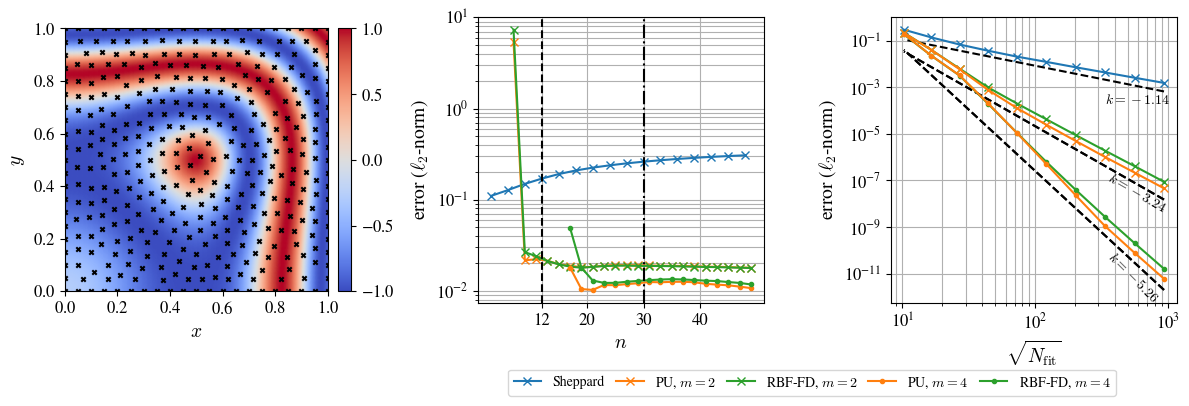

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
colors= ['tab:blue', "tab:orange", "tab:green"]

# Plot analytic.
ax = axs[0]
# ax.set_title("Domain")

p = ax.scatter(positions_test[0], positions_test[1], c=sol_analytic, marker=".", cmap="coolwarm",s=0.5)
ax.scatter(positions_fit[0], positions_fit[1], marker="x", color="k",s=10)

# Meta.
ax.set_aspect('equal')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_ymargin(0)
ax.set_xmargin(0)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(p, cax=cax)

# PLot errors

ax = axs[1]
# ax.set_title("Error")

source_files = ["../data/interpolation_mon_2.h5", "../data/interpolation_mon_4.h5"]
for source_file in source_files:
    with h5.File(source_file, 'r') as data:
        # Get data.
        for color_idx, type in enumerate(['Sheppard_sup', 'PU_sup', 'RBF-FD_sup']):
            if source_file == source_files[1] and color_idx == 0:
                continue

            ns = []
            err_2 = []
            err_inf = []
            groups = [group for group in data.keys() if type in group]
            for group in groups:
                sup = int(group.split('_')[-1])
                if (sup > 50):
                    continue
                ns.append(int(group.split('_')[-1]))
                err = np.abs(data['{}_{:02d}'.format(type, ns[-1])][:] - sol_analytic)
                err_2.append(LA.norm(err, 2)/LA.norm(sol_analytic, 2))
                err_inf.append(np.max(err))
            
            label = "{}, $m = {}$".format(type.split('_sup')[0], source_file.split("_")[-1].split(".")[0])
            if color_idx == 0:
                label= "Sheppard"
            ax.semilogy(ns, err_2, '-', label=label, color=colors[color_idx], marker="x" if source_file == source_files[0] else ".")
            # ax.semilogy(ns, err_inf, '.--', label="{}".format(type.split('_sup')[0]))

ax.axvline(12,c='black',ls='--',lw=1.5)
ax.axvline(30,c='black',ls='dashdot',lw=1.5)
ticks = list(ax.get_xticks())
ticks = [int(t) for t in ticks[1:]]
ticks.append(12)
ticks.append(30)
ticks = sorted(ticks)
ticks = ticks[:-1]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.grid(True, 'both')
ax.set_xlabel('$n$')
ax.set_ylabel('error ($\ell_2$-norm)')

fig.tight_layout()

# Plot convergence
ax = axs[2]
source_file = "../data/interpolation_conv.h5"
with h5.File(source_file, 'r') as data:
    groups = list(data.keys())
    dxs = data['conf'].attrs.get('domain.dx_fit').decode('utf-8').split(',')
    dxs = sorted([float(dx) for dx in dxs], reverse=False)
    sol_analytic = data['analytic'][:][0]


    g = [group for group in groups if "Sheppard" in group]
    name_dxs = [float(group.split('sup_')[-1]) for group in g]
    domain_sizes = [data.attrs.get('fit_points_dx_{:.3f}'.format(dx)) for dx in name_dxs]
    domain_sizes = np.power(domain_sizes, 1 / int(2))
    err_2 = []
    err_inf = []
    for group in g:
        err = np.abs(data['{}'.format(group)][:] - sol_analytic)
        err_2.append(LA.norm(err, 2)/LA.norm(sol_analytic, 2))
        err_inf.append(np.max(err))
    
    ax.loglog(domain_sizes, err_2, '-', label="Sheppard", marker="x", c = colors[0])
    k, n = np.polyfit(np.log(domain_sizes), np.log(err_2), 1)
    y = np.multiply(np.exp(n - 0.7), np.power(domain_sizes, k))
    ax.plot(domain_sizes, y, 'k--', label=None, linewidth = 1.5)
    ax.text(domain_sizes[2], y[0] *0.3, "$k = {:.2f}$".format(k))
    

    for interp in ['RBFFD', 'PU']:
        for mon in [2, 4]:
            g = [group for group in groups if "{}_mon_{:02d}".format(interp, mon) in group]

            # Get data.
            err_2 = []
            err_inf = []
            for group in g:
                err = np.abs(data['{}'.format(group)][:] - sol_analytic)
                err_2.append(LA.norm(err, 2)/LA.norm(sol_analytic, 2))
                err_inf.append(np.max(err))
            ax.loglog(domain_sizes, err_2, '-', label="{}_mon_{:02d}".format(interp, mon), marker="x" if mon == 2 else ".", c = colors[2] if interp == "RBFFD" else colors[1])
            if (interp == "RBFFD"):
                k, n = np.polyfit(np.log(domain_sizes), np.log(err_2), 1)
                y = np.multiply(np.exp(n - (2 if mon == 4 else 1.5)), np.power(domain_sizes, k))
                ax.plot(domain_sizes, y, 'k--', label=None, linewidth = 1.5)
                ax.plot(domain_sizes, y, 'k--', label=None, linewidth = 1.5)
                ax.text(domain_sizes[2], y[0] * (0.3 if mon == 4 else 0.3), "$k = {:.2f}$".format(k), rotation=-45 if mon == 4 else -30)
ax.grid(True, 'both')
ax.set_xlabel('$\sqrt{N_\mathrm{fit}}$')
ax.set_ylabel('error ($\ell_2$-norm)')

fig.tight_layout()
fig.subplots_adjust(bottom=0.23)   ##  Need to play with this number.
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(labels=labels, handles = handles, loc="lower right", ncol=5, columnspacing=0.8, bbox_to_anchor=(0.94, -0.02))

if 1:
    fig.savefig('../manuscript/paper/figures/interpolation_2d.jpg', dpi=300, transparent=False, bbox_inches='tight')

In [6]:
name_dxs

[0.001, 0.002, 0.003, 0.005, 0.008, 0.013, 0.022, 0.036, 0.06, 0.1]